In [2]:
from numba import prange, njit
from tqdm import tqdm
import matplotlib.pyplot as plt

In [61]:
import numpy as np
from numba import njit
from scipy.sparse import random,csr_matrix
from util_old import Markov_mfpt_calc, compute_free_energy

def test_MM(size,density = 0.4):
    M = random(size,size,density = density)
    MM_dense = M.toarray()
    for i in range(len(MM_dense)):
        sum = np.sum(MM_dense[i])
        MM_dense[i] = MM_dense[i]/sum
    return MM_dense
def check_kemeny(MFPT,peq):
    n = MFPT.shape[0]
    TEST = np.zeros(n)
    for i in range(n):
        for j in range(n):
            TEST[i] += MFPT[i,j] * peq[j]
    return TEST

def jjhunter(P):
    P = np.array(P, dtype=np.float64)  # Using double precision
    m = len(P)
    I = np.eye(m, dtype=np.float64)
    e1 = np.ones((m, 1), dtype=np.float64)
    E = np.ones((m, m), dtype=np.float64)
    PPD = P.copy()
    AASD = np.zeros((m, m), dtype=np.float64)
    SD = np.zeros(m)

    for n in range(m-1, 0, -1):
        #print(n,PPD[n, :n])
        SD[n] = np.sum(PPD[n, :n])
        #print(SD)
        for i in range(n):
            for j in range(n):
                AASD[i, j] = PPD[i, n] * PPD[n, j] / SD[n]
                PPD[i, j] += AASD[i, j]
    #print(AASD,'\n', PPD)

    rD = np.zeros(m, dtype=np.float64)
    rD[0] = 1
    for n in range(1, m):
        for i in range(n):
            rD[n] += rD[i] * PPD[i, n] / SD[n]

    TOTD = np.sum(rD)
    pit_1D = rD / TOTD
    PiD = e1 @ pit_1D.reshape(1, -1)
    ZD = np.linalg.inv(I - P + PiD)
    DD = np.linalg.inv(np.diag(np.diag(PiD)))
    MD = (I - ZD + E @ np.diag(np.diag(ZD))) @ DD
    return MD


def jjhunter_wrapped(P):
    @njit()
    def jjhelper(m,PPD,SD,rD):
        for n in range(m-1, 0, -1):
            #print(n,PPD[n, :n])
            SD[n] = np.sum(PPD[n, :n])
            #print(SD)
            for i in range(n):
                for j in range(n):
                    PPD[i,j] += PPD[i, n] * PPD[n, j] / SD[n]
        rD[0] = 1
        for n in range(1, m):
            for i in range(n):
                rD[n] += rD[i] * PPD[i, n] / SD[n]
        return PPD,rD
    
    P = np.array(P, dtype=np.float64)  # Using double precision
    m = len(P)
    I = np.eye(m, dtype=np.float64)
    e1 = np.ones((m, 1), dtype=np.float64)
    E = np.ones((m, m), dtype=np.float64)
    PPD = P.copy()
    rD = np.zeros(m, dtype=np.float64)
    
    PPD, rD = jjhelper(m,PPD,rD.copy(),rD)
    TOTD = np.sum(rD)
    pit_1D = rD / TOTD
    PiD = e1 @ pit_1D.reshape(1, -1)
    ZD = np.linalg.inv(I - P + PiD)
    DD = np.linalg.inv(np.diag(np.diag(PiD)))
    MD = (I - ZD + E @ np.diag(np.diag(ZD))) @ DD
    return MD

@njit(parallel=True)
def jjhelper(m,PPD,SD,rD):
    for n in range(m-1, 0, -1):
        #print(n,PPD[n, :n])
        SD[n] = np.sum(PPD[n, :n])
        #print(SD)
        for i in range(n):
            for j in range(n):
                PPD[i,j] += PPD[i, n] * PPD[n, j] / SD[n]
    rD[0] = 1
    for n in prange(1, m):
        for i in range(n):
            rD[n] += rD[i] * PPD[i, n] / SD[n]
    return PPD,rD


def jjhunter_numba(P):
    P = np.array(P, dtype=np.float64)  # Using double precision
    m = len(P)
    I = np.eye(m, dtype=np.float64)
    e1 = np.ones((m, 1), dtype=np.float64)
    E = np.ones((m, m), dtype=np.float64)
    PPD = P.copy()
    rD = np.zeros(m, dtype=np.float64)
    
    PPD, rD = jjhelper(m,PPD,rD.copy(),rD)
    TOTD = np.sum(rD)
    pit_1D = rD / TOTD
    PiD = e1 @ pit_1D.reshape(1, -1)
    ZD = np.linalg.inv(I - P + PiD)
    DD = np.linalg.inv(np.diag(np.diag(PiD)))
    MD = (I - ZD + E @ np.diag(np.diag(ZD))) @ DD
    return MD


In [ ]:
M_1000 = 

In [32]:
Markov_mfpt_calc(compute_free_energy(P.T)[0],P)

array([[3.43923244, 2.72729497, 2.17656639],
       [3.39112654, 3.17428735, 1.62641053],
       [1.58963005, 2.85398055, 2.53674406]])

In [71]:
jjhunter_wrapped(P)

array([[2.12465365, 2.41503427, 5.288825  ],
       [2.10789656, 2.82436685, 3.95190861],
       [1.03325414, 2.57366158, 5.70537237]])

In [56]:
jjhunter(P)

array([[2.12465365, 2.41503427, 5.288825  ],
       [2.10789656, 2.82436685, 3.95190861],
       [1.03325414, 2.57366158, 5.70537237]])

In [8]:
# Example matrix P
P = np.array([[0.4211, 0.4247, 0.1542],
              [0.2808, 0.2743, 0.445 ],
              [0.9873, 0.3257, 0.1018]])

# Running the function with the provided matrix
jjhunter(P)

array([[2.12465365, 2.41503427, 5.288825  ],
       [2.10789656, 2.82436685, 3.95190861],
       [1.03325414, 2.57366158, 5.70537237]])

In [6]:
%%time
jjhunter(P)

CPU times: user 404 µs, sys: 249 µs, total: 653 µs
Wall time: 479 µs


array([[2.12465365, 2.41503427, 5.288825  ],
       [2.10789656, 2.82436685, 3.95190861],
       [1.03325414, 2.57366158, 5.70537237]])

In [5]:
%%time
jjhunter_numba(P)

/home/gsaba/miniconda3/envs/biophys_env/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 1.36 s, sys: 34 ms, total: 1.39 s
Wall time: 1.51 s


array([[2.12465365, 2.41503427, 5.288825  ],
       [2.10789656, 2.82436685, 3.95190861],
       [1.03325414, 2.57366158, 5.70537237]])

In [8]:
%%time
peq = compute_free_energy(P)[0]
Markov_mfpt_calc(peq.T,P)

CPU times: user 8.59 ms, sys: 4.33 ms, total: 12.9 ms
Wall time: 5.74 ms


array([[3.43923244, 2.72729497, 2.17656639],
       [3.39112654, 3.17428735, 1.62641053],
       [1.58963005, 2.85398055, 2.53674406]])

In [9]:
def test_MFPT(func1, func2):
    for i in np.linspace(10,500,10):
        MM = test_MM(int(i))
        assert np.allclose(func1(MM),func2(MM))
    return 'all good'

In [10]:
test_MFPT(jjhunter,jjhunter_numba)

'all good'

In [11]:
#### cross checked with matlab implementation
jj_test = np.array([[0.10527377, 0.1817953 , 0.0708085 , 0.03873914, 0.18655596,
        0.05958668, 0.05948819, 0.0272113 , 0.13918155, 0.13135961],
       [0.00363416, 0.08425522, 0.16957946, 0.12625847, 0.05253766,
        0.10727298, 0.20501035, 0.06345117, 0.03550366, 0.15249685],
       [0.14614697, 0.02061316, 0.15096585, 0.18595542, 0.07533686,
        0.11858288, 0.10736863, 0.06428107, 0.00865713, 0.12209203],
       [0.15780383, 0.2008256 , 0.02980625, 0.1843092 , 0.04394148,
        0.01010617, 0.05958006, 0.17966403, 0.02727216, 0.10669121],
       [0.03509584, 0.21903654, 0.01662006, 0.03393923, 0.03569386,
        0.14582061, 0.00321775, 0.27285368, 0.09819675, 0.13952568],
       [0.07175213, 0.1681485 , 0.01510959, 0.148823  , 0.036687  ,
        0.05274501, 0.18675568, 0.00683182, 0.12230998, 0.19083728],
       [0.05244913, 0.02907043, 0.0975587 , 0.05025271, 0.02216286,
        0.17713026, 0.06328293, 0.20496622, 0.1713011 , 0.13182566],
       [0.14689875, 0.02455911, 0.01327026, 0.1102367 , 0.19563813,
        0.09531382, 0.05910418, 0.093803  , 0.13929018, 0.12188586],
       [0.10158382, 0.07613131, 0.17190665, 0.03884681, 0.06059491,
        0.05792382, 0.1240157 , 0.0682159 , 0.1556297 , 0.14515137],
       [0.13143423, 0.06999549, 0.13050877, 0.15466744, 0.05662536,
        0.1508679 , 0.05977656, 0.07543566, 0.11605682, 0.05463179]])
JJ = jjhunter_numba(jj_test)

In [13]:
np.sum(jj_test[0])

0.9999999999999999

In [15]:
peq = compute_free_energy(jj_test)[0]
mfpt1 = Markov_mfpt_calc(peq.T,jj_test)
mfpt2 = jjhunter(jj_test)
k1 = check_kemeny(mfpt1,peq)
k2 = check_kemeny(mfpt2,peq)
print(k1,k2)

[9.97614044 9.97614046 9.97614044 9.97614045 9.97614044 9.97614045
 9.97614044 9.97614045 9.97614045 9.97614042] [10.10998828 10.13988282 10.1317884  10.1636292  10.1663076  10.17746943
 10.14551257 10.11060195 10.12394789 10.1280951 ]


In [93]:
compute_free_energy(JJ)[0]
check_kemeny()

array([0.09970465, 0.09999713, 0.09991889, 0.10024037, 0.10026492,
       0.10037112, 0.10005989, 0.09971094, 0.09984852, 0.09988357])

In [91]:
for i in jj_test:
    assert np.allclose(np.sum(i),1)


In [17]:
A = test_MM(2000)
peq = compute_free_energy(A)[0]
mfpt1 = Markov_mfpt_calc(peq,A)
mfpt2 = jjhunter_numba(A)
k1 = check_kemeny(mfpt1,peq)
k2 = check_kemeny(mfpt2,peq)

In [73]:
def compare_runtime_dense(size_list):
    @njit(parallel=True)
    def normalise_transition(MM):
        for i in prange(len(MM)):
            sum = np.sum(MM[i])
            MM[i] = MM[i]/sum
        return MM
    def mfpt_calc(matrix):
        peq = compute_free_energy(matrix)[0]
        mfpt = Markov_mfpt_calc(peq,matrix)
        return peq, mfpt
    
    TIME1 = []
    TIME2 = []

    for i in tqdm(size_list):
        matrix = np.random.random((i,i))
        matrix = normalise_transition(matrix)
        time1 = %timeit -o -q mfpt_calc(matrix)
        time2 = %timeit -o -q jjhunter_numba(matrix)
        TIME1.append(time1.best)
        TIME2.append(time2.best)
    return TIME1,TIME2

In [17]:
t1, t2 = compare_runtime_dense([10,100,1000,2000,3000,4000])

100%|██████████| 6/6 [12:59<00:00, 129.91s/it]


In [75]:
T1, T2 = compare_runtime_dense(np.linspace(1,500,10).astype(int))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:36<00:00, 15.66s/it]


In [77]:
T_1, T_2 = compare_runtime_dense(np.linspace(10,1500,14).astype(int))

100%|██████████| 14/14 [03:10<00:00, 13.64s/it]


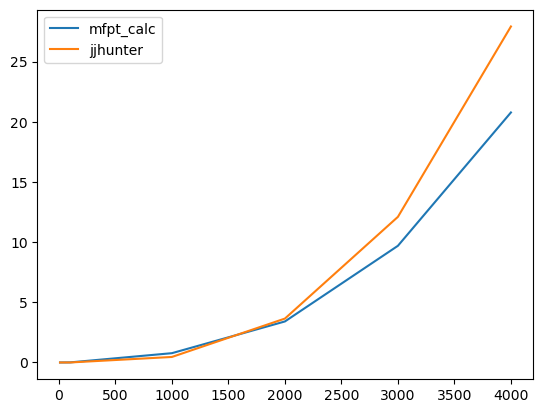

In [21]:
plt.figure()
plt.plot([10,100,1000,2000,3000,4000],t1,label='mfpt_calc')
plt.plot([10,100,1000,2000,3000,4000],t2,label='jjhunter')
plt.legend(loc='best')

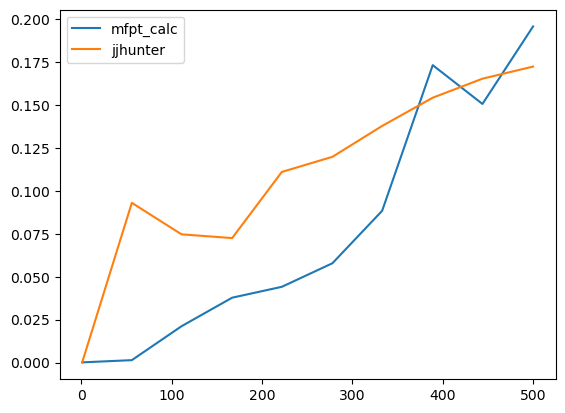

In [76]:
plt.figure()
plt.plot(np.linspace(1,500,10).astype(int),T1,label='mfpt_calc')
plt.plot(np.linspace(1,500,10).astype(int),T2,label='jjhunter')
plt.legend(loc='best')

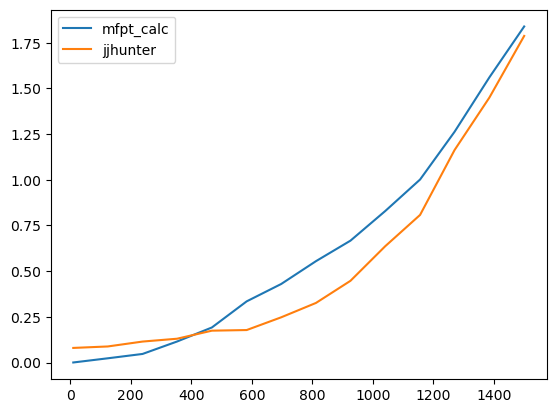

In [78]:
plt.figure()
plt.plot(np.linspace(10,1500,14).astype(int),T_1,label='mfpt_calc')
plt.plot(np.linspace(10,1500,14).astype(int),T_2,label='jjhunter')
plt.legend(loc='best')

In [ ]:
k1

array([99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89532036,
       99.89532036, 99.89532036, 99.89532036, 99.89532036, 99.89

In [96]:
k2

array([102.45847389, 102.47020634, 102.48809658, 102.43592254,
       102.46362989, 102.44462813, 102.48853149, 102.47176222,
       102.43653372, 102.44397124, 102.49371759, 102.44331937,
       102.4582134 , 102.47044974, 102.48138516, 102.50711931,
       102.46856627, 102.4764424 , 102.47029355, 102.48279344,
       102.44205585, 102.43190379, 102.52214933, 102.53815542,
       102.51031316, 102.49869685, 102.42421809, 102.48720642,
       102.50260516, 102.45372292, 102.46762989, 102.44598391,
       102.48856279, 102.51905617, 102.47532857, 102.48136783,
       102.45281255, 102.52251925, 102.44809197, 102.45296867,
       102.47974728, 102.44426694, 102.47410157, 102.486912  ,
       102.45437949, 102.4389593 , 102.44787987, 102.50527229,
       102.49998913, 102.48964122, 102.48919303, 102.4873894 ,
       102.4969996 , 102.5019802 , 102.42592613, 102.43007937,
       102.50837901, 102.4925062 , 102.46172993, 102.46704442,
       102.51214818, 102.44849088, 102.45203869, 102.44